In [ ]:
%load_ext autoreload
%autoreload 2

from functools import lru_cache
import sys
sys.path.append("../")
from os.path import join
from IPython.display import display
from functools import partial

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rc('text', usetex=True)

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = r"""
\usepackage{sansmath}
\sansmath
""" #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica, Avant Garde, Computer Modern Sans serif' # Choose a nice font here

from scipy.stats import ttest_ind, sem
import scipy
import joblib
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from scipy.stats import pearsonr
import seaborn as sns
import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_rows', 128)

from spurious_ml.datasets import add_spurious_correlation, add_colored_spurious_correlation
from spurious_ml.models.torch_utils import archs
from spurious_ml.variables import auto_var
from params import *
from utils import params_to_dataframe

fontsize=16

In [2]:
def mlp_pred_fn(X, model, device="cuda"):
    dset = torch.utils.data.TensorDataset(torch.from_numpy(X.reshape(len(X), -1)).float())
    loader = torch.utils.data.DataLoader(dset, batch_size=256)
    
    model.to(device).eval()
    fetX = []
    for (x, ) in tqdm(loader, desc="[pred_fn]"):
        fetX.append(model(x.to(device)).cpu().detach().numpy())
    fetX = np.concatenate(fetX, axis=0)
    return fetX

def cnn_pred_fn(X, model, device="cuda"):
    if len(X.shape) == 4:
        X = X.transpose(0, 3, 1, 2)
        
    dset = torch.utils.data.TensorDataset(torch.from_numpy(X).float())
    loader = torch.utils.data.DataLoader(dset, batch_size=128)
    
    model.to(device).eval()
    fetX = []
    #for (x, ) in loader:
    for (x, ) in tqdm(loader, desc="[pred_fn]"):
        fetX.append(model(x.to(device)).cpu().detach().numpy())
        #fetX.append(model.feature_extractor(x.to(device)).cpu().detach().flatten(1).numpy())
    fetX = np.concatenate(fetX, axis=0)
    return fetX

class CLF():
    def __init__(self, model):
        self.model = model
        
    def predict(self, X, device="cuda"):
        return pred_fn(X, self.model, device=device)

## BBox

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [15]:
def get_date(ds_name,):
    if 'cifar' in ds_name:
        res = joblib.load(f"../results/mem_inference/128-{ds_name}-70-0.01-aug01-ce-tor-altResNet20Norm02-0.0-adam-0-0.0.pkl")
    else:
        res = joblib.load(f"../results/mem_inference/128-{ds_name}-70-ce-tor-LargeMLP-0.0-adam-0-0.0.pkl")

    (_, tar_trny, _, tar_tsty, _, shadow_trny, _, shadow_tsty, spurious_ind) = auto_var.get_var_with_argument("dataset", ds_name)
    trnX = np.concatenate((res['aux_shadow_trn_pred'], res['aux_shadow_tst_pred']), axis=0)
    trnX = np.concatenate((
        np.sort(trnX, axis=1),
        np.concatenate(((res['aux_shadow_trn_pred'].argmax(1) == shadow_trny).astype(np.float32),
                        (res['aux_shadow_tst_pred'].argmax(1) == shadow_tsty).astype(np.float32))).reshape(-1, 1)
    ), axis=1)
    trny = np.concatenate((np.ones(len(res['aux_shadow_trn_pred'])), np.zeros(len(res['target_shadow_tst_pred']))))
    tstX = np.concatenate((res['target_tar_trn_pred'], res['target_tar_trn_pred']), axis=0)
    tstX = np.concatenate((
        np.sort(tstX, axis=1),
        np.concatenate(((res['target_tar_trn_pred'].argmax(1) == tar_trny).astype(np.float32),
                        (res['target_tar_tst_pred'].argmax(1) == tar_tsty).astype(np.float32))).reshape(-1, 1)
    ), axis=1)
    tsty = np.concatenate((np.ones(len(res['aux_tar_trn_pred'])), np.zeros(len(res['aux_tar_trn_pred']))))


    mod_tar_trn = np.concatenate((
        np.sort(res['target_tar_trn_pred'], axis=1),
        (res['target_tar_trn_pred'].argmax(1) == tar_trny).astype(np.float32).reshape(-1, 1),
    ), axis=1)
    mod_tar_tst = np.concatenate((
        np.sort(res['target_tar_tst_pred'], axis=1),
        (res['target_tar_tst_pred'].argmax(1) == tar_tsty).astype(np.float32).reshape(-1, 1),
    ), axis=1)
    
    scaler = StandardScaler()
    trnX = scaler.fit_transform(trnX)
    tstX = scaler.transform(tstX)
    mod_tar_trn = scaler.transform(mod_tar_trn)
    mod_tar_tst = scaler.transform(mod_tar_tst)
    
    return trnX, trny, tstX, tsty, mod_tar_trn, mod_tar_tst, spurious_ind


In [42]:
results = {}
#results = joblib.load("caches/meminf_results.pkl")

nspus = {
    'memfashion': [1, 3, 5, 10, 20, 100, 1000],
    'memmnist': [1, 3, 5, 10, 20, 100, 1000],
    'memcifar10': [1, 3, 5, 10, 20, 100, 1000],
}

for base_dset in ['memfashion', 'memmnist', 'memcifar10']:
    print(f"===================== {base_dset} ====================")
    results.setdefault(base_dset, dict())
    for i in tqdm(nspus[base_dset]):
        res = results[base_dset].setdefault(i, dict())
        temp = {'tst_acc': [], 'spu_tst_acc': [], 'clfs': []}
        for rs in tqdm(range(10)):
            if 'tst_acc' in res and len(res['tst_acc']) > rs:
                temp['clfs'].append(res['clfs'][rs])
                temp['tst_acc'].append(res['tst_acc'][rs])
                temp['spu_tst_acc'].append(res['spu_tst_acc'][rs])
                continue
            if i == 0:
                if rs != 0:
                    continue
                ds_name = base_dset.replace("sp", "")
                ds_name = f"{ds_name}v20"
            else:
                ds_name = f"{base_dset}v20-{i}-0-{rs}"

            trnX, trny, tstX, tsty, mod_tar_trn, mod_tar_tst, spurious_ind = get_date(ds_name)

            clf = GridSearchCV(LogisticRegression(), param_grid={"C": [0.01, 0.1, 1.0, 10.0]}, n_jobs=12, cv=3)
            clf.fit(trnX, trny)
            #print(i, clf.score(trnX, trny), clf.score(tstX, tsty))
            #(clf.predict(mod_tar_trn) == 1).mean(), (clf.predict(mod_tar_tst) == 0).mean()
            if len(np.shape(spurious_ind)) == 2:
                ind = spurious_ind[0]
            else:
                ind = spurious_ind
            temp['clfs'].append(clf)
            temp['tst_acc'].append(clf.score(tstX, tsty))
            temp['spu_tst_acc'].append(clf.score(tstX[ind], tsty[ind]))
        res['tst_acc'] = temp['tst_acc']
        res['spu_tst_acc'] = temp['spu_tst_acc']
        res['clfs'] = temp['clfs']
            #print(clf.best_estimator_.coef_)
            #print("avg one prediction", clf.predict(mod_tar_trn).mean(), clf.predict(mod_tar_tst).mean())
            #print(clf.score(tstX[ind], tsty[ind]), len(ind))
#joblib.dump(results, "caches/meminf_results.pkl")

===================== memfashion ====================


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

===================== memmnist ====================


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

===================== memcifar10 ====================


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [31]:
joblib.dump(results, "caches/meminf_results.pkl")

['caches/meminf_results.pkl']

memfashion
1 0.5281314285714285 0.9 0.09999999999999999
3 0.5308514285714286 0.9333333333333332 0.044444444444444446
5 0.5299028571428572 0.82 0.10519822558706331
10 0.5281714285714285 0.71 0.12948616399703355
20 0.5300400000000001 0.5149999999999999 0.14162744555111248
100 0.5302114285714286 0.20299999999999999 0.10872033439569209
1000 0.5308742857142856 0.2962 0.13573984922146726


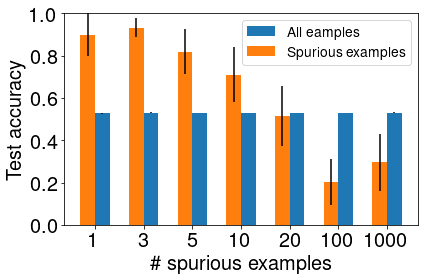

memmnist
1 0.5137885714285714 0.7 0.15275252316519464
3 0.5141114285714286 0.7666666666666666 0.1319371343004213
5 0.5137628571428572 0.82 0.10934146311237815
10 0.5137257142857142 0.76 0.132664991614216
20 0.5137885714285715 0.745 0.13342705039750288
100 0.5134285714285716 0.5990000000000001 0.150646385065601
1000 0.5143914285714286 0.613 0.15303173236656217


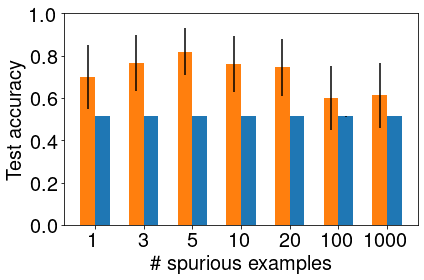

memcifar10
1 0.5617533333333332 1.0 0.0
3 0.5636466666666666 1.0 0.0
5 0.56267 0.9400000000000001 0.04268749491621898
10 0.5624866666666667 0.9800000000000001 0.013333333333333329
20 0.5620499999999999 0.99 0.006666666666666672
100 0.5615433333333333 0.9800000000000001 0.01220200347848208
1000 0.5675333333333332 0.9996 0.00040000000000000034


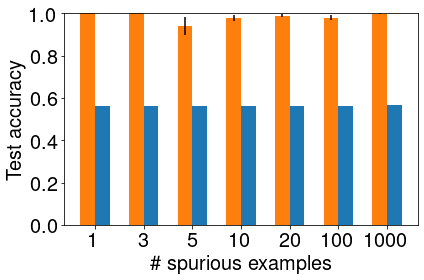

In [35]:
#results = joblib.load("caches/meminf_results.pkl")
fontsize = 20

#for base_dset in ['memfashion', 'spmemfashion', 'memmnist', 'spmemmnist', ]:
for base_dset in ['memfashion', 'memmnist', 'memcifar10']:
    print(base_dset)
    nspu = nspus[base_dset]
    tstaccs, spu_tstaccs = [], []
    for i in nspu:
        tstaccs.append(results[base_dset][i]['tst_acc'])
        spu_tstaccs.append(results[base_dset][i]['spu_tst_acc'])
        print(i, 
              np.mean(results[base_dset][i]['tst_acc']),
              np.mean(results[base_dset][i]['spu_tst_acc']),
              sem(results[base_dset][i]['spu_tst_acc']))
    tstaccs, spu_tstaccs = np.array(tstaccs), np.array(spu_tstaccs)
    
    #plt.figure(figsize=(8, 4))
    width = 0.3
    plt.bar(np.arange(len(nspu)) + width/2, tstaccs.mean(1), yerr=sem(tstaccs, axis=1), width=width, label="All eamples")
    plt.bar(np.arange(len(nspu)) - width/2, spu_tstaccs.mean(1), yerr=sem(spu_tstaccs, axis=1), width=width, label="Spurious examples")
    
    plt.ylim(0., 1.0)
    plt.yticks(fontsize=fontsize)
    plt.ylabel("Test accuracy", fontsize=fontsize)
    plt.xticks(np.arange(len(nspu)), labels=nspu, fontsize=fontsize)
    plt.xlabel("\# spurious examples", fontsize=fontsize)
    if 'fashion' in base_dset:
        plt.legend(fontsize=fontsize-6)
    plt.tight_layout()
    
    plt.savefig(f"./figs/meminf/{base_dset}_bbox.png")
    plt.show()
    